In [105]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary

In [106]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal
# from tqdm.notebook import tqdm

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [108]:
# hyper parameter
num_classes = 30
close_num = 14 # 14, 19, 24, 29
batch_size = 64
learning_rate = 0.0001
num_epochs = 300
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)
# overlap = 0 # overlapをなくして実験する用
# threshold = 0.99
# thresholds = [0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99]
# close_nums = [14, 19, 24, 29]
alpha = 0.1

Text(0, 0.5, 'Amplitude')

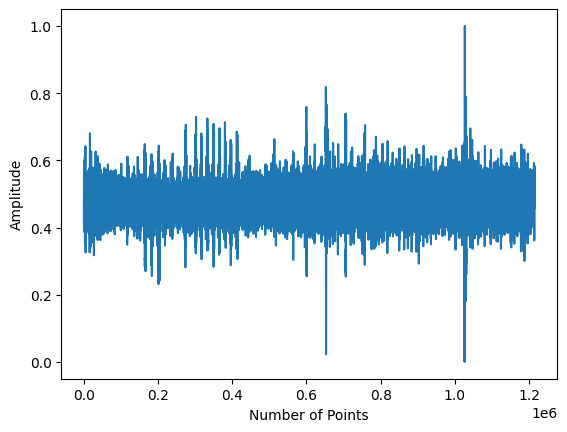

In [109]:
scaler = MinMaxScaler()
radar_frame = pd.read_csv("./data/radar_01.csv")
radar_frame = scaler.fit_transform(radar_frame)
plt.plot(radar_frame)
plt.xlabel("Number of Points")
plt.ylabel("Amplitude")

In [110]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

In [99]:
radar_frame_list[0][0]

[array([-1.02175754e-04, -9.22608829e-05, -8.13242751e-05, ...,
        -1.04579331e-04, -1.05501685e-04, -1.05595623e-04])]

In [111]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1)

labels_series = pd.Series(labels)

In [27]:
labels_series

0        0
1        0
2        0
3        0
4        0
        ..
5437    20
5438    20
5439    20
5440    20
5441    20
Length: 5442, dtype: int64

In [112]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    # print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

((5413,), tensor([ 0,  0,  0,  ..., 15, 15, 15]), torch.Size([5413]))

In [101]:
tmp.shape

(5413,)

In [113]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 
        self.fc_tsne = nn.Linear(nf * 4, 2)
        self.two_vecs_train = [] # list is faster in appending
        self.two_vecs_test = []

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        # two_dimensional_vec = self.fc_tsne(x)
        # if self.training:
        #     self.two_vecs_train.append(two_dimensional_vec.tolist()) # あとでネストしたものをまとめてtensorかndarrayに変換するため
        # else:
        #     self.two_vecs_test.append(two_dimensional_vec.tolist())
        x = self.fc(x)
        return x

Reshapeかviewで(-1, 128, 2)の形にする

ちゃんと望んだ形と要素になっているか確認する

In [ ]:
twoV = np.array(model.two_vecs_train)
twoV = np.reshape(twoV, (-1, 128, 2))
twoV.shape

In [175]:
def save_feature_mapping(self, features, labels):
    if self.traing: # Train mode
        two_vecs = model.two_vecs[-1].cpu().detach().numpy().copy()
        x, y = zip(*two_vecs)
        fig = plt.scatter(x, y)
        plt.savefig(fig)
    else: # Eval mode
        two_vecs = model.two_vecs[-1].cpu().detach().numpy().copy()
        x, y = zip(*two_vecs)
        fig = plt.scatter(x, y)
        plt.savefig(fig)

In [68]:
# from tsai.models.utils import count_parameters

In [114]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [63]:
dataset[0][1], dataset[4473][1], dataset[4474][1], dataset[len(dataset)-1][1]

(tensor(0), tensor(24), tensor(25), tensor(25))

In [83]:
dataset[3570][1], dataset[3571][1]

(tensor(19), tensor(20))

In [10]:
dataset[2691][1], dataset[2692][1]

/tmp/ipykernel_840/3033810394.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)


(tensor(14), tensor(15))

In [34]:
dataset[1885][1], dataset[1886][1]

(tensor(10), tensor(10))

In [64]:
train_size = int(0.8 * len(data_series.values))
test_size = len(data_series.values) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size]) # check whether each data and label set is synchronized 
print(f"full: {len(dataset)} -> train: {len(train_set)}, test: {len(test_set)}")

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

full: 5413 -> train: 4330, test: 1083


Additional processing for Open Set

e.g.
train 0~24

test 0~30

concat

In [115]:
split_idx = 2691
indices1 = np.arange(split_idx)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
indices2 = np.arange(split_idx + 1, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29
Unknown_label = close_num + 1

In [116]:
dataset1[-1][1], dataset2[0][1], dataset2[-1][1]

(tensor(14), tensor(15), tensor(15))

In [73]:
# indices1 = np.arange(4473)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-24
# indices2 = np.arange(4474, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 25-30
# Unknown_label = close_num + 1

In [74]:
# indices1 = np.arange(3570)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-19
# indices2 = np.arange(3571, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 20-30
# Unknown_label = close_num + 1

In [111]:
# indices1 = np.arange(2691)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
# indices2 = np.arange(2692, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29
# Unknown_label = close_num + 1

#### open_train_set: 0-14のindexしか含まない学習セット
#### open_test_set: 0-14, 15(unknown)のindexを含むテストセット

In [117]:
train_size1 = int(0.80 * len(dataset1))
test_size1 = len(dataset1) - train_size1

train_size2 = int(0.80 * len(dataset2))
test_size2 = len(dataset2) - train_size2

open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])

indices = np.arange(len(test_set2))
test_set2 = torch.utils.data.Subset(test_set2, indices[:])

train : test = 8 : 2 → 3 : 1で分ける

In [118]:
open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])
len(open_train_set), len(open_test_set)

(2152, 1084)

In [119]:
train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False) # テストでシャッフルしても同じ、図示のためならTrue

## Triple Joint Loss

In [81]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)

center_loss_test = CenterLoss(num_classes=close_num + 2, feat_dim=close_num + 2, use_gpu=True)
optimizer_centloss_test = torch.optim.SGD(center_loss_test.parameters(), lr=0.05)

class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha, isTest=False):
    # alpha: hyper parameter
    # output_only_truth = []
    # for idx, x in enumerate(output):
    #     x = x[labels[idx]]
    #     x = torch.tensor(x).to(device)
    #     output_only_truth.append([x])
    # output_only_truth = torch.tensor(output_only_truth)
    # output_only_truth = output_only_truth.float()
    # output_only_truth = output_only_truth.to(device)
    # print(output.is_cuda, output_only_truth.is_cuda, label.is_cuda)
    if isTest: # validation lossはクラス数を変える必要があるため分岐
        return softmax_loss(output, label) + alpha * center_loss_test(output, label)
    return softmax_loss(output, label) + alpha * center_loss(output, label)
    # return softmax_loss(output, label) + alpha * center_loss(output, label) + cos_loss(output, label)
    # return cos_loss(output_only_truth, label)

In [120]:
model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [121]:
from fastprogress.fastprogress import master_bar, progress_bar
mb = master_bar(range(num_epochs))

In [122]:
model.train()
n_total_steps = len(train_loader)
for epoch in mb:
  for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    outputs = outputs.to(device)
    # print(outputs)
    # loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    optimizer_centloss.zero_grad()
    loss.backward()
    # for param in center_loss.parameters():
      # param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
    optimizer.step()
    # optimizer_centloss.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
  mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

/tmp/ipykernel_840/3169792528.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


Epoch [1/`300], Step [12/34], Loss: 2.5340
Epoch [1/`300], Step [24/34], Loss: 2.3467
Epoch [2/`300], Step [12/34], Loss: 2.0919
Epoch [2/`300], Step [24/34], Loss: 2.0405
Epoch [3/`300], Step [12/34], Loss: 1.9655
Epoch [3/`300], Step [24/34], Loss: 1.8447
Epoch [4/`300], Step [12/34], Loss: 1.6677
Epoch [4/`300], Step [24/34], Loss: 1.6134
Epoch [5/`300], Step [12/34], Loss: 1.5493
Epoch [5/`300], Step [24/34], Loss: 1.3425
Epoch [6/`300], Step [12/34], Loss: 1.3249
Epoch [6/`300], Step [24/34], Loss: 1.4438
Epoch [7/`300], Step [12/34], Loss: 1.3313
Epoch [7/`300], Step [24/34], Loss: 1.1320
Epoch [8/`300], Step [12/34], Loss: 1.2591
Epoch [8/`300], Step [24/34], Loss: 1.0914
Epoch [9/`300], Step [12/34], Loss: 1.0023
Epoch [9/`300], Step [24/34], Loss: 1.2409
Epoch [10/`300], Step [12/34], Loss: 0.9386
Epoch [10/`300], Step [24/34], Loss: 0.8706
Epoch [11/`300], Step [12/34], Loss: 0.8554
Epoch [11/`300], Step [24/34], Loss: 0.9219
Epoch [12/`300], Step [12/34], Loss: 0.7370
Epoch 

KeyboardInterrupt: 

### plot feature map

In [123]:
from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap
import seaborn as sns

num_class = 16

def _show_2D_XXX(cls, many_dim_vector, target, title, figsize, labels):
    many_dim_vector_reduced = cls(n_components=2, random_state=0).fit_transform(many_dim_vector)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # levels = MaxNLocator(nbins=10).tick_values(0,10)-.0001
    # cmap = plt.get_cmap('jet')
    # norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # color_list = ["#E60012", "#F39800", "#FFF100", "#8FC31F","#009944", "#009E96", "#00A0E9", "#0068B7", "#1D2088", "#920783", "#E4007F", "#E5004F"]
    # cmap = ListedColormap(sns.color_palette(color_list, 12))
    label = [str(i) for i in range(num_class)]
    cax = ax.scatter(many_dim_vector_reduced[:, 0], many_dim_vector_reduced[:, 1], label=label, c=target, cmap='jet')
    ax.set_title(title)
    # cbar = fig.colorbar(cax, ticks=sorted(list(set(target))))
    legend1 = ax.legend(*cax.legend_elements(num=12), loc="best", title="Class")
    ax.add_artist(legend1)
    if labels is not None:
        cbar.ax.set_yticklabels(labels)
    return fig, ax


def show_2D_tSNE(many_dim_vector, target, title='Feature Map Visualization', figsize=(8, 6), labels=None):
    return _show_2D_XXX(TSNE, many_dim_vector, target, title, figsize, labels)

/tmp/ipykernel_840/2359805369.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: title={'center': 'Feature Map Visualization'}>)

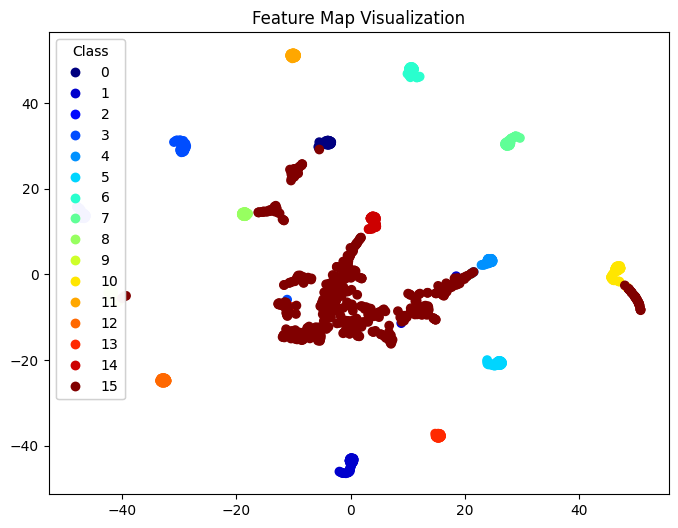

In [124]:
threshold = 0.6
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False) # False -> to make visualize map fixed
model.eval()
    # for threshold in thresholds:
predicted_list = np.empty((0, 15))
one_hot_labels_list = np.empty(0)
with torch.no_grad():
    softmax = nn.Softmax()
    for i, (signals, one_hot_labels) in enumerate(test_loader):
        validation_step_loss = []
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(signals)
        for j, out in enumerate(outputs):
            outputs[j] = softmax(out)

        _, predicted = torch.max(outputs.data, 1) # predicted per batch size
          
        for idx in range(len(_)):
          if _[idx] < threshold:
            predicted[idx] = Unknown_label # 15, 20, 25
        # predicted_cp = predicted.to('cpu').detach().numpy().copy()
        # one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
        # predicted_lists = np.concatenate([predicted_lists, predicted_cp])
        # one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
        predicted_list = np.append(predicted_list, outputs.cpu(), axis=0)
        one_hot_labels_list = np.append(one_hot_labels_list, one_hot_labels.cpu())
        
show_2D_tSNE(predicted_list, one_hot_labels_list) # predicted listはoutputsの集めたやつ

In [103]:
len(predicted_list), len(predicted_list[0]), len(one_hot_labels_list)

(1084, 15, 2168)

### Learning Curve (Close set)

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)

mean_acc = 0
num_epochs = 300

model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from fastprogress.fastprogress import master_bar, progress_bar
mb = master_bar(range(num_epochs))

# Prepare the List
all_train_features = []
all_train_labels = []
all_test_features = []
all_test_labels = []
training_epoch_loss = []
validation_epoch_loss = []

#****************************Train*************************************
n_total_steps = len(train_loader)
for epoch in mb:
    model.train()
    training_step_loss = []
    for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        labels = labels.to(device)
        outputs = model(signals)
        outputs = outputs.to(device)
        loss = triple_joint_loss(outputs, labels, alpha)
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optimizer.step()
        optimizer_centloss.step()
        training_step_loss.append(loss.item())
    mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))
    training_epoch_loss.append(np.array(training_step_loss).mean())


#*******************************Test***********************************
    # model.eval()
    # # for threshold in thresholds:
    # predicted_lists = np.zeros(0, dtype=np.int64)
    # one_hot_labels_list = np.zeros(0, dtype=np.int64)
    # with torch.no_grad():
    #     softmax = nn.Softmax()
    #     for i, (signals, one_hot_labels) in enumerate(test_loader):
    #         validation_step_loss = []
    #         signals = torch.tensor(signals)
    #         signals = signals.float()
    #         signals = signals.to(device)
    #         one_hot_labels = one_hot_labels.to(device)
    #         outputs = model(signals)
    #         validation_loss = triple_joint_loss(outputs, one_hot_labels, alpha)
    #         validation_step_loss.append(validation_loss.item())
    #         # show_2D_tSNE(outputs, one_hot_labels)
    #     validation_epoch_loss.append(np.array(validation_step_loss).mean())
    # print(training_epoch_loss[-1], validation_epoch_loss[-1])

/tmp/ipykernel_840/4274057818.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

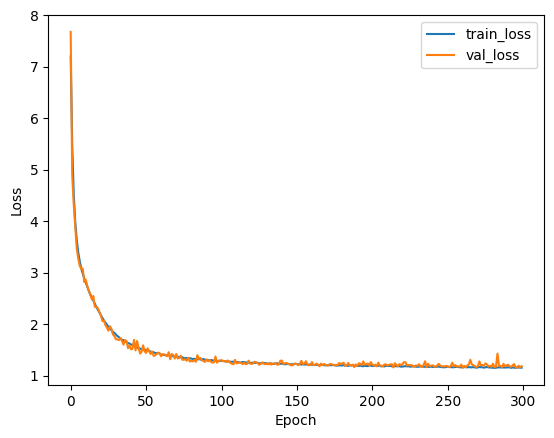

In [70]:
plt.plot(training_epoch_loss, label='train_loss')
plt.plot(validation_epoch_loss,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show

### Learning Curve (open setでできないか試行錯誤)

In [ ]:
model.train()
n_total_steps = len(train_loader)
softmax = nn.Softmax()


training_epoch_loss = []
validation_epoch_loss = []
threshold = 0.6

for epoch in mb:
  training_step_loss = []
  for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    for j, out in enumerate(outputs): # これ消すとthreshold処理がちゃんとできない
        outputs[j] = softmax(out)
    outputs = outputs.to(device)
    # print(outputs)
    loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels

    optimizer.zero_grad()
    optimizer_centloss.zero_grad()
    loss.backward()
    for param in center_loss.parameters():
      param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
    optimizer.step()
    optimizer_centloss.step()
    training_step_loss.append(loss.item())
    # if (i + 1) % 12 == 0:
      # print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
  mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))
  training_epoch_loss.append(np.array(training_step_loss).mean())

#*******************************Test***********************************
  model.eval()
  # for threshold in thresholds:
  predicted_lists = []
  one_hot_labels_list = []
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      for i, (signals, one_hot_labels) in enumerate(test_loader):
          validation_step_loss = []
          signals = torch.tensor(signals)
          signals = signals.float()
          signals = signals.to(device)
          one_hot_labels = one_hot_labels.to(device)
          outputs = model(signals)
          outputs_for_loss = outputs # softmax後のoutputsで計算するのがlossが下がらない原因と予想

          # for j, out in enumerate(outputs): # これ消すとthreshold処理がちゃんとできない
          #     outputs[j] = softmax(out)

          _, predicted = torch.max(outputs.data, 1) # predicted per batch size
          
          outputs_extend = []
          for i in range(len(outputs_for_loss)):
              zero = torch.tensor([0]).to(device)
              outputs_extend_row = torch.cat((outputs_for_loss[i], zero), 0) # 0を後ろに追加，あとはつなげる
              outputs_extend.append(outputs_extend_row)
          outputs_extend = torch.stack(outputs_extend, dim=0)

          for idx in range(len(_)):
              if _[idx] < threshold: # maxの値を並べててしきい値以下なら15を代入
                  predicted[idx] = Unknown_label # 15, 20, 25
                  outputs_extend[idx, -1] = 1.0
                  outputs_extend[idx, :-1] = 0.0
                  # print(outputs_extend)

          validation_loss = triple_joint_loss(outputs_extend, one_hot_labels, alpha, isTest=True)
          validation_step_loss.append(validation_loss.item())

          optimizer_centloss_test.zero_grad() # できればcenter_lossの学習も行わせたい
          # for param in center_loss_test.parameters():
          #     param.grad.data *= (1./alpha)
          optimizer_centloss_test.step()
          # show_2D_tSNE(outputs, one_hot_labels)

          # n_samples += one_hot_labels.size(0) # add batch_size
          # n_correct += (predicted == one_hot_labels).sum().item()
          
          # predicted_cp = predicted.to('cpu').detach().numpy().copy()
          # one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
          # predicted_lists = np.concatenate([predicted_lists, predicted_cp])
          # one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
          
          # acc = 100.0 * n_correct / n_samples
          # print(f'{n_correct} / {n_samples} = Acc: {acc} %, loss: {validation_loss}')
      validation_epoch_loss.append(np.array(validation_step_loss).mean())
  print(training_epoch_loss[-1], validation_epoch_loss[-1])

labelは0-24までだから，学習はいじらなくて大丈夫

testはOpen setの場合，0~24とUnknown label(25)になるから，labelは作り直し

25も出力するようなネットワークにしなきゃだめ

In [124]:
threshold = 0.65

In [125]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    # if i == 1:
    
      # print(outputs)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    
    
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    print(_, predicted, one_hot_labels)

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

/tmp/ipykernel_840/3423637234.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


TensorBase([0.9945, 0.9996, 0.9911, 0.9765, 0.9999, 0.9990, 0.9985, 0.9992,
            0.9999, 0.9902, 0.9917, 0.9982, 0.9968, 0.9989, 0.9998, 0.9967,
            0.9990, 0.9987, 0.9964, 0.9979, 0.9996, 0.9997, 0.9988, 0.9968,
            0.9998, 0.9958, 0.9981, 0.9998, 0.9992, 0.9993, 0.9993, 0.9999,
            0.9980, 0.9990, 0.9913, 0.9968, 0.9843, 0.9878, 0.9994, 0.9994,
            0.9998, 0.9997, 0.9931, 0.9989, 0.9995, 0.9994, 0.9987, 0.9998,
            0.9996, 1.0000, 0.9995, 0.9994, 0.9725, 0.9987, 0.9979, 0.9987,
            0.9987, 0.9997, 0.9949, 1.0000, 0.9997, 0.9972, 0.9994, 0.9941],
           device='cuda:0') TensorBase([ 8,  4, 11, 11, 14, 10,  0,  9,  7, 13, 12,  4,  5,  0, 11,  1,  3,
             0,  4, 12,  0,  7,  3,  2,  8, 11,  8, 10,  9,  3, 11, 14, 10,  9,
             1,  7, 14, 11,  6,  0,  3,  6, 11,  8,  0, 10,  6,  5, 10, 10,  0,
            11,  2,  7,  4,  7,  4, 10, 12, 14,  3,  2,  3,  2],
           device='cuda:0') tensor([ 8,  4, 11, 11, 14, 10

: 

https://github.com/Vastlab/libMR.git

In [181]:
predicted_cp, one_hot_labels_cp

(array([ 4, 15, 15,  9, 15, 15, 10, 14, 15, 15,  1, 12,  6, 15,  3,  4,  0,
        15, 15, 15,  3, 15, 15, 15,  4, 15,  8, 15, 15,  8, 15, 15, 15, 15,
        15, 15,  0,  7,  3, 15, 15, 15,  2, 12, 15, 15, 15,  6, 14, 10, 15,
        11, 15, 15,  0, 15, 10, 12,  8,  5]),
 array([ 4, 15, 15,  9, 15, 15, 10, 14, 15, 15,  1, 12,  6, 15,  3,  4,  0,
        15, 15, 15,  3, 15, 15, 15,  4, 15,  8, 15, 15,  8, 15, 15, 15, 15,
        15, 15,  0,  7,  3, 15, 15, 15,  2, 12, 15, 15, 15,  6, 14, 10, 15,
        11, 15, 15,  0, 15, 10, 12,  8,  5]))

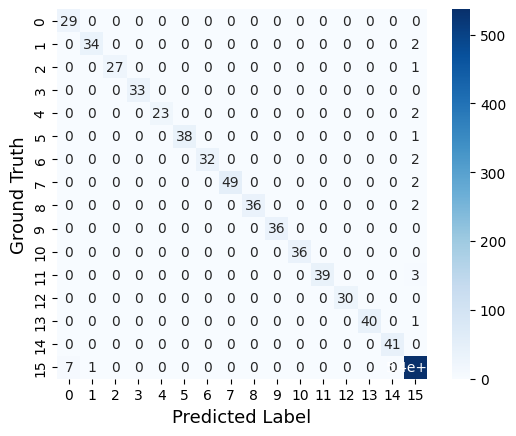

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
fig_name = "sklearn_confusion_matrix_{}_{}.png".format(Unknown_label, threshold)
# plt.savefig("./figure/" + fig_name)

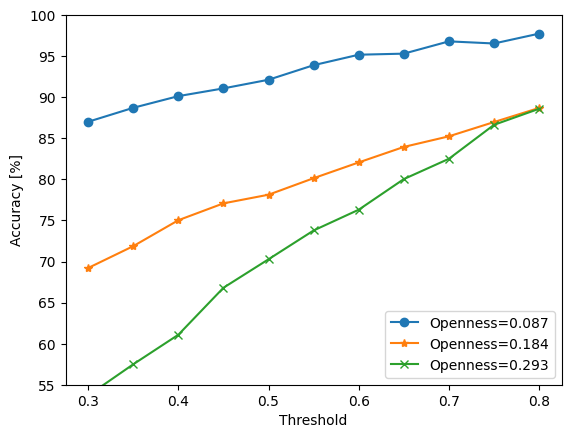

In [14]:
a = np.array([55.35055350553505, 61.99261992619926, 64.11439114391143, 70.75645756457564, 74.6309963099631, 73.5239852398524, 77.58302583025831, 84.5940959409594, 81.91881918819188, 90.59040590405904, 88.46863468634686])
b = np.array([55.71955719557196, 57.564575645756456, 61.62361623616236, 70.9409594095941, 71.58671586715867, 76.56826568265683, 75.27675276752767, 76.19926199261992, 81.2730627306273, 84.96309963099631, 88.00738007380073])
c = np.array([51.93726937269373, 54.7970479704797, 58.025830258302584, 62.08487084870849, 66.32841328413284, 71.03321033210332, 74.72324723247233, 78.50553505535055, 81.91881918819188, 84.77859778597787, 87.82287822878229])
d = np.array([52.859778597785976, 56.91881918819188, 61.254612546125465, 66.14391143911439, 70.84870848708488, 75.46125461254613, 78.87453874538745, 82.10332103321034, 85.05535055350553, 87.63837638376384, 90.59040590405904])
e = np.array([52.5830258302583, 56.18081180811808, 60.42435424354244, 64.11439114391143, 67.98892988929889, 72.32472324723247, 75.09225092250922, 78.78228782287823, 82.380073800738, 85.23985239852398, 88.09963099630997])
ave14 = np.mean([a, b, c, d, e], axis=0)

a1 = np.array([68.88273314866113, 73.40720221606648, 77.65466297322253, 78.67036011080333, 78.76269621421976, 84.57987072945522, 83.28716528162512, 87.44228993536473, 85.96491228070175, 88.9196675900277, 88.73499538319483])
b1 = np.array([69.3444136657433, 71.46814404432133, 76.08494921514313, 78.02400738688827, 78.30101569713759, 76.5466297322253, 83.10249307479225, 83.28716528162512, 87.07294552169898, 87.6269621421976, 90.2123730378578])
c1 = np.array([69.43674976915975, 71.83748845798708, 74.33056325023084, 76.36195752539243, 78.20867959372114, 81.4404432132964, 83.10249307479225, 85.68790397045245, 86.79593721144968, 89.10433979686057, 91.68975069252078])
d1 = np.array([68.69806094182826, 70.3601108033241, 72.11449676823638, 74.42289935364728, 75.53093259464451, 76.73130193905817, 78.02400738688827, 78.76269621421976, 80.33240997229917, 81.80978762696215, 84.11819021237304])
e1 = np.array([69.71375807940905, 72.29916897506925, 74.9769159741459, 77.93167128347184, 79.87072945521699, 81.4404432132964, 82.82548476454294, 84.57987072945522, 86.0572483841182, 87.44228993536473, 88.73499538319483])

ave19 = np.mean([a1, b1, c1, d1, e1], axis=0)

a2 = np.array([88.36565096952909, 91.87442289935365, 91.59741458910435, 93.62880886426593, 92.89012003693445, 93.90581717451524, 96.67590027700831, 95.10618651892891, 98.33795013850416, 95.38319482917821, 97.78393351800554])
b2 = np.array([87.90397045244691, 88.82733148661127, 91.59741458910435, 88.6426592797784, 91.2280701754386, 94.73684210526316, 94.73684210526316, 93.72114496768236, 95.93721144967682, 95.66020313942752, 97.04524469067405])
c2 = np.array([85.87257617728532, 87.53462603878117, 89.47368421052632, 91.59741458910435, 92.05909510618652, 93.25946445060019, 93.8134810710988, 95.01385041551247, 95.8448753462604, 96.67590027700831, 97.96860572483841])
d2 = np.array([86.88827331486611, 88.18097876269621, 89.38134810710989, 90.39704524469067, 91.5050784856879, 92.89012003693445, 94.45983379501385, 95.29085872576178, 96.02954755309327, 96.86057248384118, 97.4145891043398])
e2 = np.array([86.0572483841182, 87.16528162511543, 88.6426592797784, 91.13573407202216, 92.98245614035088, 94.73684210526316, 96.21421975992614, 97.4145891043398, 97.87626962142198, 98.15327793167128, 98.52262234533703])

ave24 = np.mean([a2, b2, c2, d2, e2], axis=0)

x = np.linspace(0.30, 0.80, 11)
y1 = ave14
y2 = ave19
y3 = ave24
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
# plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y3, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y1, marker="x", label="Openness=0.293")
plt.legend()

In [16]:
y1, y2, y3

(array([53.6900369 , 57.49077491, 61.08856089, 66.80811808, 70.27675277,
        73.78228782, 76.3099631 , 80.03690037, 82.50922509, 86.64206642,
        88.59778598]),
 array([69.21514312, 71.8744229 , 75.03231764, 77.08217913, 78.13481071,
        80.14773777, 82.06832872, 83.95198523, 85.24469067, 86.98060942,
        88.69806094]),
 array([87.01754386, 88.71652816, 90.13850416, 91.08033241, 92.13296399,
        93.90581717, 95.1800554 , 95.30932595, 96.80517082, 96.54662973,
        97.74699908]))

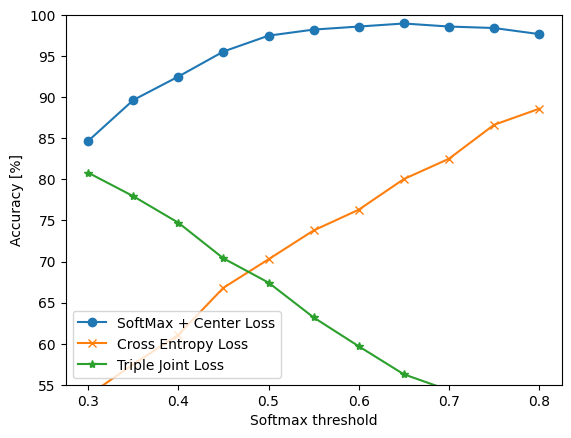

In [184]:
x = np.linspace(0.30, 0.80, 11)
y1 = ave14

y_soft_center = [84.68, 89.66, 92.52, 95.57, 97.50, 98.24, 98.61,  98.98, 98.61, 98.43, 97.69]
y_triple = [80.81, 77.95,  74.72, 70.38, 67.43, 63.19, 59.68, 56.27, 54.33, 52.21, 50.92]
plt.ylim(55, 100)
plt.xlabel("Softmax threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y_soft_center, marker="o", label="SoftMax + Center Loss")
plt.plot(x, y1, marker="x", label="Cross Entropy Loss")
plt.plot(x, y_triple, marker="*", label="Triple Joint Loss")

plt.legend()


model.two_vecsは 6817 * 64(batch_size) * 2になっちゃってる

正規化された値？訓練かテストのときの値なのか，softmaxを通っているのかはっきりさせる必要あり

In [185]:
two_vecs = model.two_vecs_train[-1].cpu().detach().numpy().copy()
x, y = zip(*two_vecs)
plt.scatter(x, y)

AttributeError: 'list' object has no attribute 'cpu'

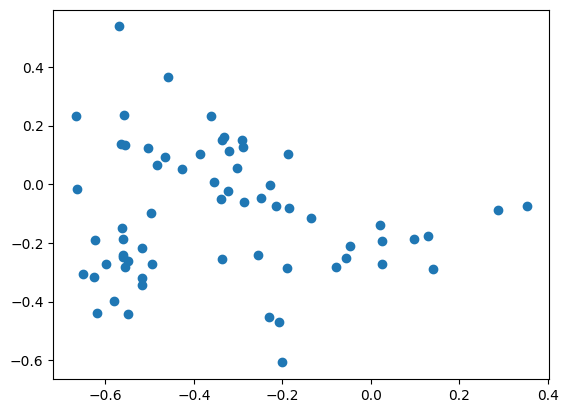

In [ ]:
two_vecs = model.two_vecs_test[2].cpu().detach().numpy().copy()
x, y = zip(*two_vecs)
plt.scatter(x, y)

In [186]:
labels_1epoch = []
for i, data in enumerate(train_loader):
    x, y = data
    if i != 32 and i != 33: # don't append batch 33, 34
        labels_1epoch.append(torch.Tensor.tolist(y))

labels_1epoch_np = np.array(labels_1epoch)
labels_1epoch_reshaped = np.reshape(labels_1epoch_np, (16, 128))
labels_1epoch_reshaped.shape

(16, 128)

In [187]:
tmp = model.two_vecs_train[:]
for i, t in reversed(list(enumerate(tmp))):
    if len(t) != batch_size or i % 33 == 0:
        # print(i, len(t))
        del tmp[i]

tmp = np.array(tmp)
tmp.shape

(9600, 64, 2)

In [188]:
tmp_reshaped = np.reshape(tmp, (4800, 128, 2))
tmp_reshaped.shape

(4800, 128, 2)

In [189]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.get_cmap("tab20").colors)
color_map = {0:(0.121, 0.466, 0.705), 1:(0.682, 0.780, 0.909), 2:(1.0, 0.498, 0.054), 3:(1.0, 0.7333333333333333, 0.47058823529411764), 4:(0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 5:(0.596078431372549, 0.8745098039215686, 0.5411764705882353), 6:(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 7:(1.0, 0.596078431372549, 0.5882352941176471), 8:(0.5803921568627451, 0.403921568627451, 0.7411764705882353), 9:(0.7725490196078432, 0.6901960784313725, 0.8352941176470589), 10:(0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 11:(0.7686274509803922, 0.611764705882353, 0.5803921568627451), 12:(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), 13:(0.9686274509803922, 0.7137254901960784, 0.8235294117647058), 14:(0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 15:(0.7803921568627451, 0.7803921568627451, 0.7803921568627451)}

In [190]:
tmp_reshaped.shape, labels_1epoch_reshaped.shape

((4800, 128, 2), (16, 128))

001_00_Fmap.png
001_01_Fmap.png
001_02_Fmap.png
001_03_Fmap.png
001_04_Fmap.png
001_05_Fmap.png
001_06_Fmap.png
001_07_Fmap.png
001_08_Fmap.png
001_09_Fmap.png
001_10_Fmap.png
001_11_Fmap.png
001_12_Fmap.png
001_13_Fmap.png
001_14_Fmap.png
001_15_Fmap.png
002_00_Fmap.png
002_01_Fmap.png
002_02_Fmap.png
002_03_Fmap.png
002_04_Fmap.png
002_05_Fmap.png
002_06_Fmap.png
002_07_Fmap.png
002_08_Fmap.png
002_09_Fmap.png
002_10_Fmap.png
002_11_Fmap.png
002_12_Fmap.png
002_13_Fmap.png
002_14_Fmap.png
002_15_Fmap.png
003_00_Fmap.png
003_01_Fmap.png
003_02_Fmap.png
003_03_Fmap.png
003_04_Fmap.png
003_05_Fmap.png
003_06_Fmap.png
003_07_Fmap.png
003_08_Fmap.png
003_09_Fmap.png
003_10_Fmap.png
003_11_Fmap.png
003_12_Fmap.png
003_13_Fmap.png
003_14_Fmap.png
003_15_Fmap.png
004_00_Fmap.png
004_01_Fmap.png
004_02_Fmap.png
004_03_Fmap.png
004_04_Fmap.png
004_05_Fmap.png
004_06_Fmap.png
004_07_Fmap.png
004_08_Fmap.png
004_09_Fmap.png
004_10_Fmap.png
004_11_Fmap.png
004_12_Fmap.png
004_13_Fmap.png
004_14_F

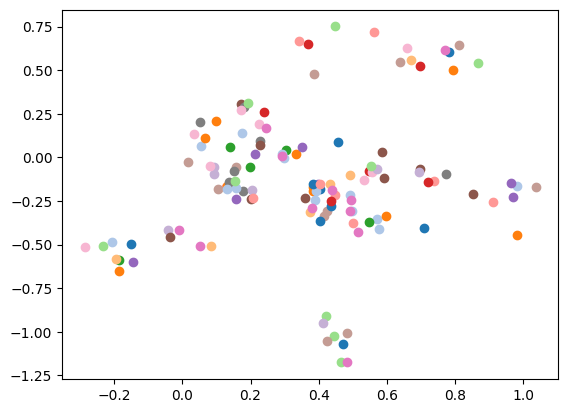

In [191]:
# 16no baisuu
epoch = 0
for i in range(4800):
    label_idx = i % 16 # (num_sample / batchsize - 2) / 2
    two_vecs = tmp_reshaped[i]
    plt.clf() # init
    if label_idx == 0:
        epoch += 1
    file_name = "%03d_%02d_Fmap.png" % (epoch, label_idx)
    print(file_name)
    for j, vec in enumerate(two_vecs):
        label = labels_1epoch_reshaped[label_idx][j]
        plt.scatter(vec[0], vec[1], color=color_map[label])
    plt.savefig("./figure/feature_map_center/" + file_name)

### Cross Validation for Open set

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい

mean_acc = 0
# split_idx = 4473
split_idx = 3570

dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

for Fold, (train_index, test_index) in enumerate(skf.split(data_series, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    open_train_index = [i for i in train_index if i <= split_idx]
    open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    # train_set = torch.utils.data.Subset(dataset, train_index)
    # test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    model.eval()
    for threshold in thresholds:
      predicted_lists = np.zeros(0, dtype=np.int64)
      one_hot_labels_list = np.zeros(0, dtype=np.int64)
      with torch.no_grad():
        n_correct = 0
        n_samples = 0
        softmax = nn.Softmax()
        for i, (signals, one_hot_labels) in enumerate(test_loader):
          signals = torch.tensor(signals)
          signals = signals.float()
          signals = signals.to(device)
          one_hot_labels = one_hot_labels.to(device)
          # print(len(one_hot_labels))
          outputs = model(signals)
          # if i == 1:
          
            # print(outputs)
          for j, out in enumerate(outputs):
            outputs[j] = softmax(out)

          _, predicted = torch.max(outputs.data, 1) # predicted per batch size
          
          for idx in range(len(_)):
            if _[idx] < threshold:
              predicted[idx] = Unknown_label # 15, 20, 25
          # print(_, predicted, one_hot_labels)

          n_samples += one_hot_labels.size(0) # add batch_size
          n_correct += (predicted == one_hot_labels).sum().item()
          
          predicted_cp = predicted.to('cpu').detach().numpy().copy()
          one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
          predicted_lists = np.concatenate([predicted_lists, predicted_cp])
          one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
          
          acc = 100.0 * n_correct / n_samples
          # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
        with open("second_cross_val_result_open.txt", "a") as f:
          f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
          f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


        cm = confusion_matrix(one_hot_labels_list, predicted_lists)
        sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
        plt.xlabel("Predicted Label", fontsize=13)
        plt.ylabel("Ground Truth", fontsize=13)
        fig_name = "second_cross_val_Fold{}_threshold{}.png".format(Fold, threshold)
        plt.savefig("./figure/cross_val_open20-10/" + fig_name)
        plt.close()
      
      if threshold == 0.6:
        mean_acc += acc
print(mean_acc / 10.0)

Fold1 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold2 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold3 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold4 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold5 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold6 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold7 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold8 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold9 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold10 Start!


/tmp/ipykernel_3945/2634342144.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_3945/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_3945/2634342144.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

96.69332451180335


In [45]:
mean_acc / 10.0

99.02098069039842

In [102]:
num_epochs = 300

### Cross validation for Close set

In [103]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい

mean_acc = 0

dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

for Fold, (train_index, test_index) in enumerate(skf.split(data_series, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    # open_train_index = [i for i in train_index if i <= split_idx]
    # open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    # open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    train_set = torch.utils.data.Subset(dataset, train_index)
    test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    # Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    # thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]
    model.eval()
    # for threshold in thresholds:
    predicted_lists = np.zeros(0, dtype=np.int64)
    one_hot_labels_list = np.zeros(0, dtype=np.int64)
    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      softmax = nn.Softmax()
      for i, (signals, one_hot_labels) in enumerate(test_loader):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        one_hot_labels = one_hot_labels.to(device)
        # print(len(one_hot_labels))
        outputs = model(signals)
        # if i == 1:
        
          # print(outputs)
        for j, out in enumerate(outputs):
          outputs[j] = softmax(out)

        _, predicted = torch.max(outputs.data, 1) # predicted per batch size
        """"""
        # for idx in range(len(_)):
          # if _[idx] < threshold:
            # predicted[idx] = Unknown_label # 15, 20, 25
        """"""
        # print(_, predicted, one_hot_labels)

        n_samples += one_hot_labels.size(0) # add batch_size
        n_correct += (predicted == one_hot_labels).sum().item()
        
        predicted_cp = predicted.to('cpu').detach().numpy().copy()
        one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
        predicted_lists = np.concatenate([predicted_lists, predicted_cp])
        one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
        
        acc = 100.0 * n_correct / n_samples
        # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
      with open("cross_val_result_close.txt", "a") as f:
        f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
        f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


      cm = confusion_matrix(one_hot_labels_list, predicted_lists)
      sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
      plt.xlabel("Predicted Label", fontsize=13)
      plt.ylabel("Ground Truth", fontsize=13)
      fig_name = "cross_val_Fold{}_close.png".format(Fold)
      plt.savefig("./figure/cross_val_close/" + fig_name)
      plt.close()
    
    # if threshold == 0.7:
    mean_acc += acc
print(mean_acc / 10.0)

Fold1 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold2 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold3 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold4 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold5 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold6 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold7 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold8 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold9 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Fold10 Start!


/tmp/ipykernel_1065/1975551596.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_1065/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_1065/1975551596.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

99.94461534264141


: 